In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [23]:
data = pd.read_csv('/home/sing/Downloads/twitter-airline-sentiment/Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569547782039728129,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,drgitlin,NaN,0,@USAirways if I try and call your reservations...,NaN,2015-02-22 09:22:27 -0800,20001,Eastern Time (US & Canada)
1,569900705852608513,negative,1.0000,Customer Service Issue,1.0000,American,NaN,tranpham18,NaN,0,@AmericanAir still no response from AA. great ...,NaN,2015-02-23 08:44:51 -0800,New York City,Eastern Time (US & Canada)
2,567742500366872576,negative,0.6581,Customer Service Issue,0.6581,United,NaN,ColtSTaylor,NaN,0,@united of course I need help. I've been DMin...,NaN,2015-02-17 09:48:54 -0800,All Over The World,NaN
3,568172843520950272,neutral,1.0000,NaN,NaN,Delta,NaN,navyseal6,NaN,0,@JetBlue I like Marie Harf go to Iraiq find IS...,"[0.0, 0.0]",2015-02-18 14:18:56 -0800,New York,Eastern Time (US & Canada)
4,568551906634797056,positive,0.6242,NaN,0.0000,American,positive,byunsamuel,NaN,0,@AmericanAir Hopefully you ll see bad ones as ...,NaN,2015-02-19 15:25:12 -0800,"Sunnyside, NY",Eastern Time (US & Canada)


In [24]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,negative,@USAirways if I try and call your reservations...
1,negative,@AmericanAir still no response from AA. great ...
2,negative,@united of course I need help. I've been DMin...
3,neutral,@JetBlue I like Marie Harf go to Iraiq find IS...
4,positive,@AmericanAir Hopefully you ll see bad ones as ...


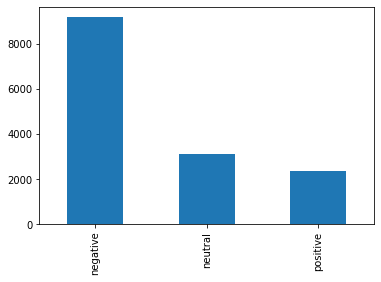

In [25]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

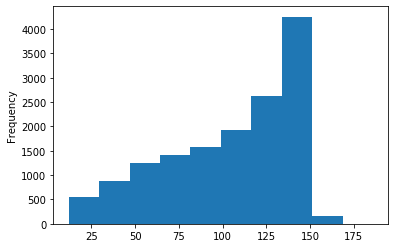

In [26]:
data['text'].str.len().plot.hist()

In [27]:
#preprocessing

data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,negative,@USAirways if I try and call your reservations...
1,negative,@AmericanAir still no response from AA. great ...
2,negative,@united of course I need help. I've been DMin...
3,neutral,@JetBlue I like Marie Harf go to Iraiq find IS...
4,positive,@AmericanAir Hopefully you ll see bad ones as ...


In [30]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase


0        @usairways if i try and call your reservations...
1        @americanair still no response from aa. great ...
2        @united of course i need help.  i've been dmin...
3        @jetblue i like marie harf go to iraiq find is...
4        @americanair hopefully you ll see bad ones as ...
                               ...                        
14635    @jetblue i have a disabled seat in row 6 do i ...
14636    @united loses my luggage and @hotelstonight lo...
14637    @jetblue, i normally ❤️ you, but this late fli...
14638    @americanair got off the phone w/ rep now flig...
14639    @southwestair you're killing me!! always #dela...
Name: text, Length: 14640, dtype: object

In [34]:
import re
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0    USAirways if I try and call your reservations ...
1    AmericanAir still no response from AA great jo...
2    united of course I need help  Ive been DMing y...
3    JetBlue I like Marie Harf go to Iraiq find ISI...
4    AmericanAir Hopefully you ll see bad ones as o...
Name: text, dtype: object

In [35]:

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,   12,   65,    3,
         383,   10,   83,   21,  472,  221,   49,  173,  324,    2,   96,
          39,   85,   49,    3,   32,    9,   62,    7,   40,   90,  102],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   13,   72,   28,  194,   33,  193,  113,  401,  104],
       [   0,    0,    0,    0,    0,    0,    0,    0,    5,   18,  909,
           3,   75,   46,  112,   45, 2459,    6, 2723,   10, 4604,   67,
         118,   21,  111, 1257,   14,  272,    7,    2,  203,   10,  296],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          17,    3,   94, 3098,  127,    1,  243, 3670,   10, 2460,  132,
          10,  494, 3099,   42,    1, 3670,   15, 1027,    1,  243, 3100],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          13,  674,    6, 4605,  1

In [36]:
#creating model
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [37]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [38]:

y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
neutral [0 1 0]
positive [0 0 1]


[None, None, None, None, None]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:

batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

/home/sing/anaconda3/envs/speechrec/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
 - 203s - loss: 0.6536 - accuracy: 0.7300
Epoch 2/8
 - 180s - loss: 0.4480 - accuracy: 0.8285
Epoch 3/8
 - 131s - loss: 0.3593 - accuracy: 0.8665
Epoch 4/8
 - 133s - loss: 0.3062 - accuracy: 0.8859
Epoch 5/8
 - 127s - loss: 0.2636 - accuracy: 0.9039
Epoch 6/8
 - 132s - loss: 0.2244 - accuracy: 0.9176
Epoch 7/8
 - 110s - loss: 0.1921 - accuracy: 0.9308
Epoch 8/8
 - 123s - loss: 0.1674 - accuracy: 0.9381


In [41]:
model.save('sentiment_analysis.h5')

In [42]:
#TEsting Model
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

USAirways if I try and call your reservations line will someone answer the phone now or will I be on hold for an hour again [0.9861529  0.01270859 0.00113854] [1 0 0]
AmericanAir still no response from AA great job guys [0.8210056  0.15639386 0.02260057] [1 0 0]
united of course I need help  Ive been DMing you ladies and gents all day Your only solution is hope for the best and LAX [0.9864205  0.00487067 0.00870873] [1 0 0]
JetBlue I like Marie Harf go to Iraiq find ISIS and spread good and offer resume service to ISIS in order to find jobs marieharf [0.03265537 0.953638   0.01370656] [0 1 0]
AmericanAir Hopefully you ll see bad ones as opportunity to get better and not dwell in it and the good ones as encouragement words [0.96559036 0.01722514 0.01718444] [1 0 0]


[None, None, None, None, None]

In [43]:

pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 477
Neutral predictions: 514
Negative predictions: 1937
Real positive: 458
Real neutral: 624
Real negative: 1846
